# Neoclassical transport calculations for axisymmetric plasmas

## `SymbolicEquilibrium`

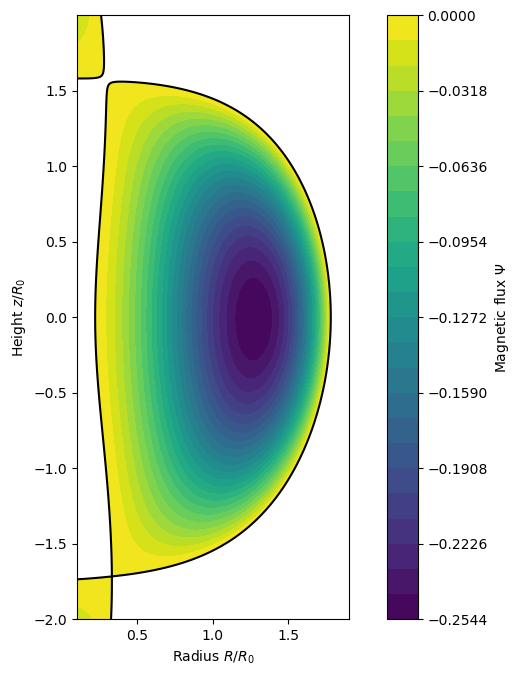

In [1]:
from plasmaboundaries import NSTX_single_null

NSTX_single_null

NSTX_Bt0 = 0.3 * u.T
NSTX_R0 = 0.8 * u.m
NSTX_a0 = 0.64 * u.m
NSTX_I = 1 * u.MA
from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = {"aspect_ratio": 0.32, "A": -0.155, "elongation": 1.7, "triangularity": 0.33}
eq = SymbolicEquilibrium(
    **NSTX_single_null,
    B0=NSTX_Bt0.si.value,  # TODO handle quantity input
    config="single-null"
)
rminmaxstep = (
    0.1,
    1.9,
    0.001,
)  # these definitely, unfortunately, need to be moved into SymbolicEquilibrium
zminmaxstep = (-2, 2, 0.001)
eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep);

## `FluxSurface`

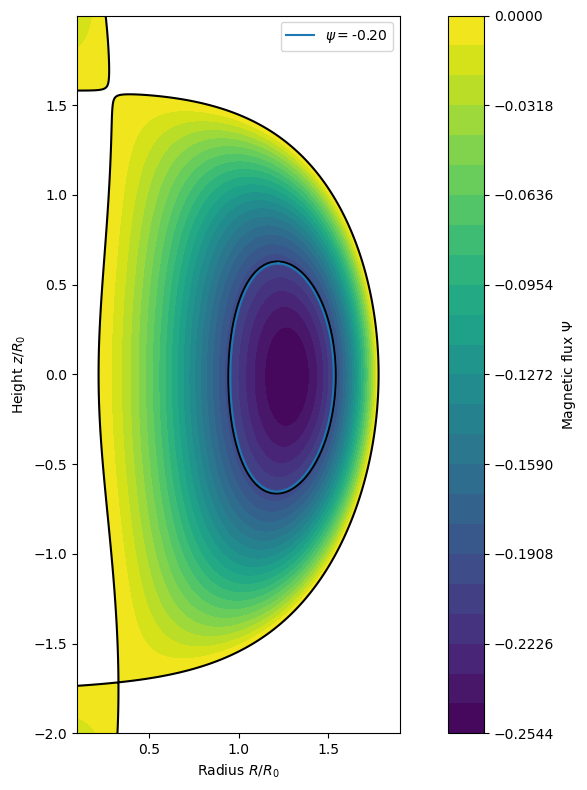

In [2]:
ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
flux_surface = eq.get_flux_surface(
    psi_value=-0.2,
    # TODO allow either psi_value or rho_value
    rminmaxstep=rminmaxstep,
    zminmaxstep=zminmaxstep,
)  # TODO call this by effective_radius
flux_surface.plot(ax, n=True)
plt.tight_layout()
# plt.savefig("/home/dominik/Writing/blog/images/fluxsurface.png")

## Define particles in our simulation

In [3]:
import astropy.units as u
import numpy as np

from plasmapy.particles import IonizationStateCollection

all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)

<IonizationStateCollection for: H, C>

In [4]:
import xarray

## Multiple flux surfaces - radial grid

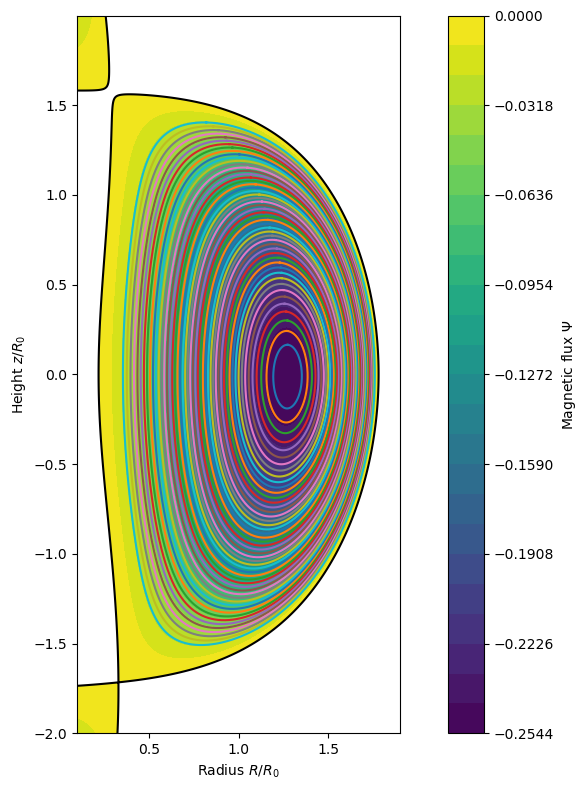

In [6]:
ax = eq.plot(rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
psi = np.linspace(-0.25, -0.023, 50)
surfaces = list(
    eq.get_multiple_flux_surfaces(psi, rminmaxstep=rminmaxstep, zminmaxstep=zminmaxstep)
)  # TODO handle multiple contours; just find closed ones
for fs in surfaces:
    fs.plot(ax)
ax.legend().remove()
plt.tight_layout()
# plt.savefig("/home/dominik/Writing/blog/images/fluxsurfacegrid.png")

## `FlowCalculator`

In [63]:
surfaces[0]

FluxSurface(R=array([1.27394038, 1.27334778, 1.27234833, ..., 1.27534667, 1.27434722,
       1.27394038]), Z=array([0.16445875, 0.16449647, 0.16453253, ..., 0.16434116, 0.16443274,
       0.16445875]), psi=-0.25, Brvals=array([-0.03875354, -0.03874911, -0.03873553, ..., -0.03875775,
       -0.03875654, -0.03875354]), Bzvals=array([0.00184877, 0.00121277, 0.00013945, ..., 0.0033579 , 0.00228559,
       0.00184877]), Bphivals=array([0.29949229, 0.29963168, 0.29986704, ..., 0.29916205, 0.29939668,
       0.29949229]), Bprimervals=array([0.07284229, 0.05522852, 0.02546492, ..., 0.11449098, 0.08492156,
       0.07284229]), Bprimezvals=array([0.22379685, 0.22300461, 0.22152707, ..., 0.22542649, 0.22430493,
       0.22379685]), GradRho2=array([0.03775374, 0.03766123, 0.03753947, ..., 0.0380429 , 0.03782904,
       0.03775374]))

In [92]:
rho_vals = psi / psi.min()  # TODO
# also TODO my rho is already normalized

array([1.        , 0.98146939, 0.96293878, 0.94440816, 0.92587755,
       0.90734694, 0.88881633, 0.87028571, 0.8517551 , 0.83322449,
       0.81469388, 0.79616327, 0.77763265, 0.75910204, 0.74057143,
       0.72204082, 0.7035102 , 0.68497959, 0.66644898, 0.64791837,
       0.62938776, 0.61085714, 0.59232653, 0.57379592, 0.55526531,
       0.53673469, 0.51820408, 0.49967347, 0.48114286, 0.46261224,
       0.44408163, 0.42555102, 0.40702041, 0.3884898 , 0.36995918,
       0.35142857, 0.33289796, 0.31436735, 0.29583673, 0.27730612,
       0.25877551, 0.2402449 , 0.22171429, 0.20318367, 0.18465306,
       0.16612245, 0.14759184, 0.12906122, 0.11053061, 0.092     ])

In [93]:
rho_to_surface = {rho: surfaces[i] for i, rho in enumerate(rho_vals)};

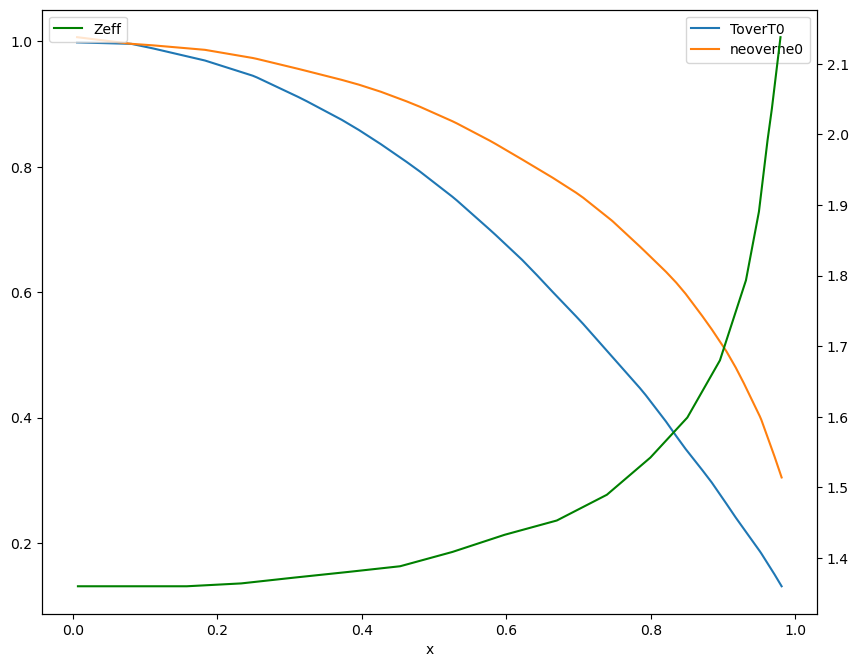

In [68]:
T_data = pd.read_csv("/home/dominik/houlberg-profiles.csv").drop("Zeff", axis=1)

zeff = pd.read_csv("/home/dominik/houlberg-profiles-zeff.csv")

fig, ax = plt.subplots()
T_data.plot(x="x", ax=ax)
ax2 = plt.twinx()
zeff.plot(x="x", ax=ax2, c="g")
plt.legend()

# TODO opisać Sławkowi logikę z wywnioskowywania z tego kompozycji plazmy

In [69]:
import sympy
sympy.init_printing()
rho, T0, Ta, ne0, nea, nC, e, = sympy.symbols("rho T_0 T_a n_{e0} n_{ea} n_{C-6+} e")
n_i = sympy.Function('n_i')(rho)

In [70]:
T_i = (T0 - Ta) * (1 - rho**2) + Ta

In [71]:
T_e = T_i
n_e = (ne0 - nea) * sympy.sqrt(1 - rho**2) + nea

In [72]:
n_C6 = nC

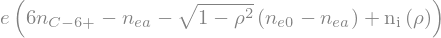

In [73]:
charge_density = (n_i + 6 * n_C6 - n_e) * e

In [74]:
T_C6 = T_i

In [75]:
n_i_solution = sympy.solve(charge_density, n_i)[0]

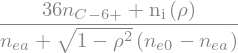

In [76]:
Z_eff = (n_i + 6**2 * n_C6)/n_e

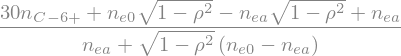

In [77]:
Z_eff.subs(n_i, n_i_solution).simplify()

      fun: 0.012943704088280742
 hess_inv: array([[0.00237366]])
      jac: array([1.74622983e-09])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([0.13728105])

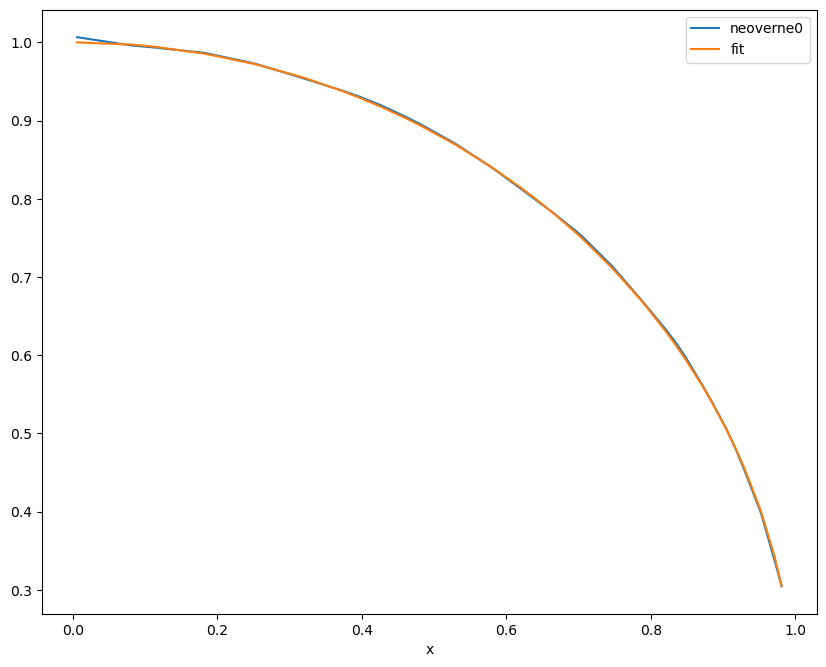

In [78]:
T_data.plot(x='x', y="neoverne0")
n_e_func = sympy.lambdify((nea, rho), n_e.subs({ne0: 1}))
n_e_func_1p = lambda nea: n_e_func(nea, T_data.x)
diff2 = lambda nea: np.linalg.norm(n_e_func_1p(nea) - T_data.neoverne0)
from scipy import optimize
n_minimization = optimize.minimize(diff2, 0.1)
display(n_minimization)

n_e_profile = n_e_func_1p(n_minimization.x)
plt.plot(T_data.x, n_e_profile, label="fit")
plt.legend()

      fun: 0.007022608609574225
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.6429193e-09])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 14
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([0.09874966])

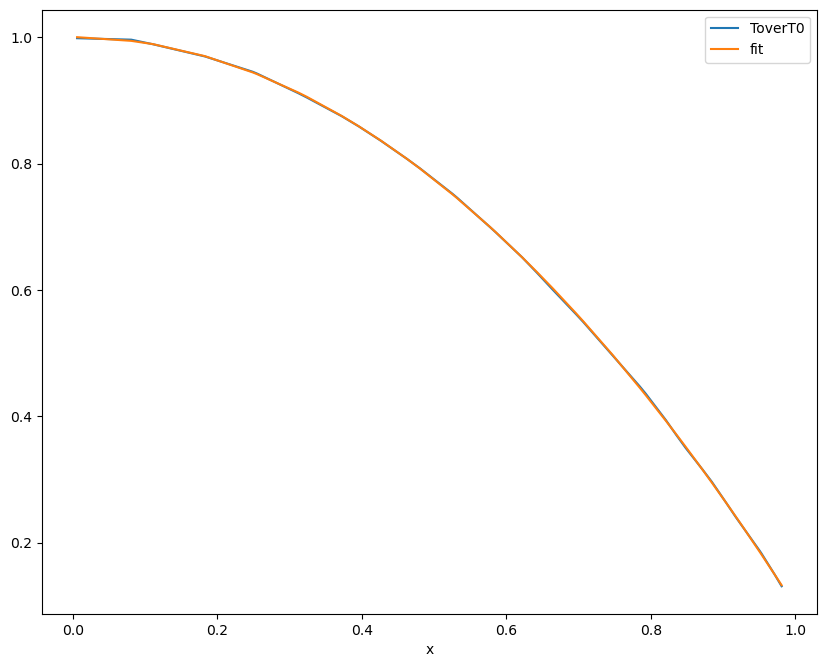

In [79]:
T_data.plot(x='x', y="ToverT0")
T_func = sympy.lambdify((Ta, rho), T_e.subs({T0: 1}))
T_func_1p = lambda Ta: T_func(Ta, T_data.x)
diff2 = lambda Ta: np.linalg.norm(T_func_1p(Ta) - T_data.ToverT0)
from scipy import optimize
T_minimization = optimize.minimize(diff2, 0.1, bounds=[(0, None)])
display(T_minimization)

T_profile = T_func_1p(T_minimization.x)
plt.plot(T_data.x, T_profile, label="fit")
plt.legend()

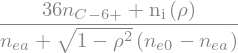

In [80]:
Z_eff

In [81]:
Z_eff_data = sympy.Function("Z_eff^D")(rho)

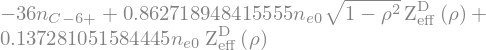

In [82]:
difference = sympy.solve(Z_eff - Z_eff_data, n_i)[0].subs({nea: n_minimization.x[0] * ne0, Ta: T_minimization.x[0] * T0})

In [83]:
Z_eff_file = pd.read_csv("/home/dominik/houlberg-profiles-zeff.csv")

,x,Zeff
0,0.00678,1.35992
1,0.08213,1.35992
2,0.15749,1.35992
3,0.23284,1.36397
4,0.30517,1.37207
5,0.38051,1.38017
6,0.45284,1.38828
7,0.52516,1.40853
8,0.59747,1.43284
9,0.66978,1.45309


In [84]:
difference.diff(ne0)

In [85]:
diff_func = sympy.lambdify((n_C6, ne0, Z_eff_data, rho), difference)
diff_func_grad = sympy.lambdify((n_C6, ne0, Z_eff_data, rho), difference.diff(ne0))
optimizable = lambda ne0: np.linalg.norm(diff_func(5e18, ne0 / 1e20, Z_eff_file.Zeff, Z_eff_file.x))
optimizable_grad = lambda ne0: np.linalg.norm(diff_func_grad(5e18, ne0 / 1e20, Z_eff_file.Zeff, Z_eff_file.x))

<function __main__.<lambda>(ne0)>

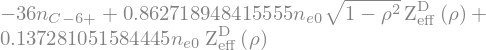

In [86]:
difference

In [87]:
difference.diff(ne0)

In [88]:
optimizable(5)

In [89]:
optimize.minimize(optimizable, 1, bounds=[(0, None)])

      fun: 7.846018098373212e+20
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.])

In [99]:
T_i_vals, dT_i_vals = -

TypeError: cannot unpack non-iterable Add object

In [90]:
# from astropy import constants
# e_charge_density = -n_e * constants.e.si
# C6_charge_density = n_C6 * 6 * constants.e.si
# proton_charge_density = 0 - e_charge_density - C6_charge_density
# plt.plot(rho, e_charge_density, label="e-")
# plt.plot(rho, C6_charge_density, label="C 6+")
# plt.plot(rho, proton_charge_density, label="p+")
# plt.legend()
# plt.figure()
# n_i = proton_charge_density / constants.e.si
# plt.plot(rho, n_e)
# plt.plot(rho, n_C6)
# plt.plot(rho, n_i)

In [94]:
# import xarray

dataset_H1 = xarray.Dataset(
    {
        "T": ("psi", T_i),
        "gradT": ("psi", dTi),
        "n": ("psi", n_e),
        "gradn": ("psi", dn_e),
    },
    coords={"psi": psi, "particle": "H 1+"},
    attrs={
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    },
)

dataset_C6 = xarray.Dataset(
    {
        "T": ("psi", T_i),
        "gradT": ("psi", dTi),
        "n": ("psi", n_C6),
        "gradn": ("psi", jnp.zeros_like(n_C6)),
    },
    coords={"psi": psi, "particle": "C 6+"},
    attrs={
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    },
)
dataset_e = xarray.Dataset(
    {
        "T": ("psi", T_e),
        "gradT": ("psi", dTi),
        "n": ("psi", n_e),
        "gradn": ("psi", dn_e),
    },
    coords={"psi": psi, "particle": "e-"},
    attrs={
        "T unit": u.eV,
        "n unit": u.m ** -3,
        "gradT unit": u.eV / u.m,
        "gradn unit": u.m ** -3 / u.m,
    },
)

dataset = xarray.concat([dataset_H1, dataset_C6, dataset_e], dim="particle")
dataset['rho'] = ('psi', rho_vals)
dataset

NameError: name 'dTi' is not defined

In [36]:
from tqdm import auto as tqdm

from plasmapy.transport.flows import FlowCalculator

fcs = []
import warnings

N = dataset.psi.size
assert N == len(surfaces)
for ρ, surface in tqdm.tqdm(zip(dataset.psi, surfaces), total=N):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fcs.append(FlowCalculator.from_xarray_surface(dataset.sel(psi=ρ), surface))
    except Exception as e:
        display(e)

  0%|          | 0/50 [00:00<?, ?it/s]

e- is not currently handled: The particle e- is not an element, so this attribute is not available.


plasmapy.utils.exceptions.PhysicsError('You cannot have a collision for zero velocity!')

e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.
e- is not currently handled: The particle e- is not an element, so this attribute is not available.


In [42]:
results = xarray.concat([fc.to_dataset() for fc in tqdm.tqdm(fcs)], dim="psi")
results = results.swap_dims({"psi": "rho"})
scaling = (fcs[0].bootstrap_current.unit / NSTX_Bt0).to(u.MA / u.m**2)
results = results.assign(bootstrap_current_normalized = results.bootstrap_current * scaling)

<xarray.Dataset>
Dimensions:                       (particle: 3, rho: 49)
Coordinates:
  * particle                      (particle) <U4 'C 6+' 'H 1+' 'e-'
    psi                           (rho) float64 -0.2454 -0.2407 ... -0.023
  * rho                           (rho) float64 0.9815 0.9629 ... 0.1105 0.092
Data variables: (12/16)
    total_particle_flux           (rho, particle) float64 -1.041e+23 ... nan
    total_heat_flux               (rho, particle) float64 -1.062e+04 ... nan
    BP_particle_flux              (rho, particle) float64 -1.041e+23 ... nan
    BP_heat_flux                  (rho, particle) float64 -8.891e+03 ... nan
    CL_particle_flux              (rho, particle) float64 4.14e+19 ... nan
    CL_heat_flux                  (rho, particle) float64 -1.263e+03 ... nan
    ...                            ...
    bootstrap_current             (rho) float64 144.3 125.0 ... 86.64 72.86
    T                             (rho, particle) float32 0.3672 ... 9.915
    gradT                         (rho, particle) float32 -19.63 ... -1.84
    n                             (rho, particle) float32 1e+19 ... 9.958e+19
    gradn                         (rho, particle) float32 0.0 ... -9.147e+18
    bootstrap_current_normalized  (rho) float64 0.0004809 ... 0.0002429

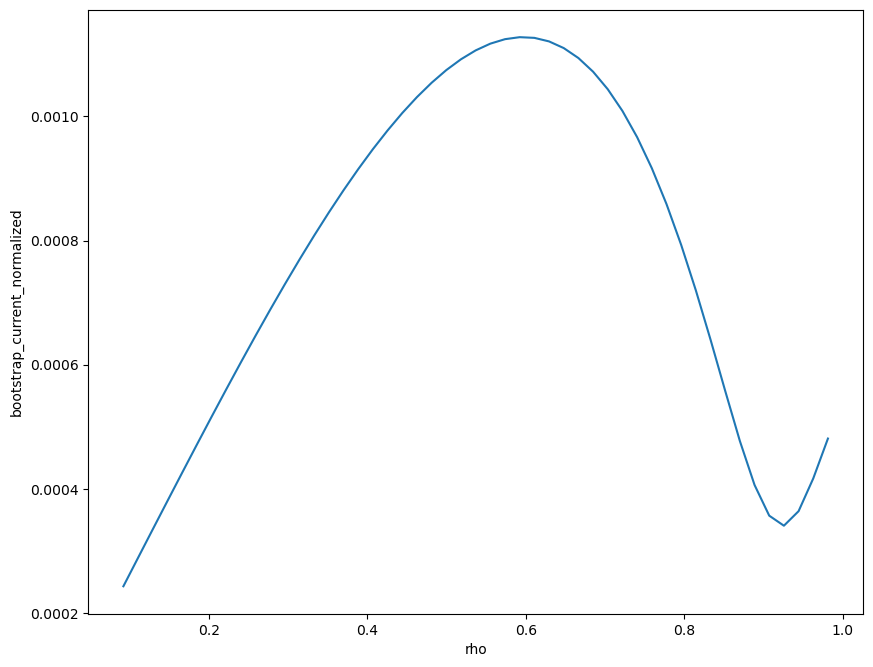

In [43]:
results.bootstrap_current_normalized.plot.line()

In [44]:
results.thermal_conductivity

<xarray.DataArray 'thermal_conductivity' (rho: 49, particle: 3)>
array([[-0.04660765, -0.1970884 ,         nan],
       [-0.09804201, -0.26676327,         nan],
       [-0.15496363, -0.3112913 ,         nan],
       [-0.20892219, -0.33987833,         nan],
       [-0.25289332, -0.35522835,         nan],
       [-0.28427335, -0.36067994,         nan],
       [-0.3037052 , -0.35958162,         nan],
       [-0.31355362, -0.35464292,         nan],
       [-0.31629713, -0.34768083,         nan],
       [-0.31409467, -0.33985379,         nan],
       [-0.3087454 , -0.33187908,         nan],
       [-0.3013675 , -0.32408854,         nan],
       [-0.29281672, -0.31668326,         nan],
       [-0.28373473, -0.30973864,         nan],
       [-0.27432158, -0.30323253,         nan],
       [-0.26492969, -0.2971736 ,         nan],
       [-0.25572214, -0.29153616,         nan],
       [-0.2467998 , -0.28627396,         nan],
       [-0.23809279, -0.28133678,         nan],
       [-0.22977221, -0.27670818,         nan],
...
       [-0.16273557, -0.24062342,         nan],
       [-0.15723951, -0.23759115,         nan],
       [-0.15193347, -0.23460532,         nan],
       [-0.14670636, -0.23164923,         nan],
       [-0.1416121 , -0.22871966,         nan],
       [-0.13658501, -0.22579017,         nan],
       [-0.13162724, -0.22286486,         nan],
       [-0.12672814, -0.21992252,         nan],
       [-0.12184711, -0.21694719,         nan],
       [-0.1169536 , -0.21392808,         nan],
       [-0.11204036, -0.21084484,         nan],
       [-0.10707328, -0.20768326,         nan],
       [-0.10203065, -0.20441115,         nan],
       [-0.09690347, -0.20100245,         nan],
       [-0.09161269, -0.19742255,         nan],
       [-0.08616792, -0.19362205,         nan],
       [-0.08053903, -0.18954185,         nan],
       [-0.07464957, -0.1851032 ,         nan],
       [-0.06852334, -0.18019784,         nan],
       [-0.06211069, -0.1746758 ,         nan]])
Coordinates:
  * particle  (particle) <U4 'C 6+' 'H 1+' 'e-'
    psi       (rho) float64 -0.2454 -0.2407 -0.2361 ... -0.03227 -0.02763 -0.023
  * rho       (rho) float64 0.9815 0.9629 0.9444 0.9259 ... 0.1291 0.1105 0.092

In [45]:
results.diffusion_coefficient.sel(particle="C 6+")

<xarray.DataArray 'diffusion_coefficient' (rho: 49)>
array([inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
       inf, inf, inf, inf, inf, inf, inf, inf, inf, inf])
Coordinates:
    particle  <U4 'C 6+'
    psi       (rho) float64 -0.2454 -0.2407 -0.2361 ... -0.03227 -0.02763 -0.023
  * rho       (rho) float64 0.9815 0.9629 0.9444 0.9259 ... 0.1291 0.1105 0.092

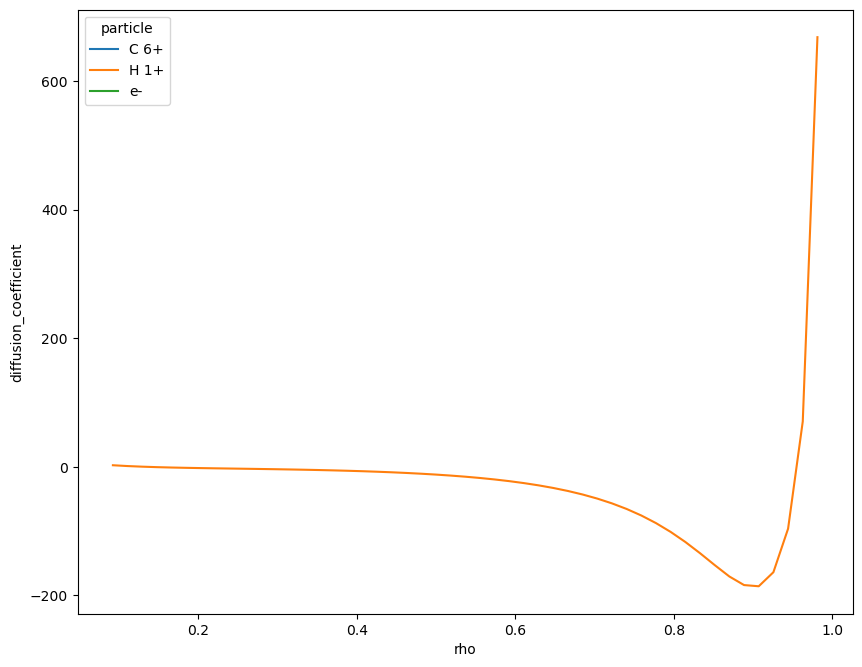

In [46]:
results.diffusion_coefficient.plot.line(x="rho")

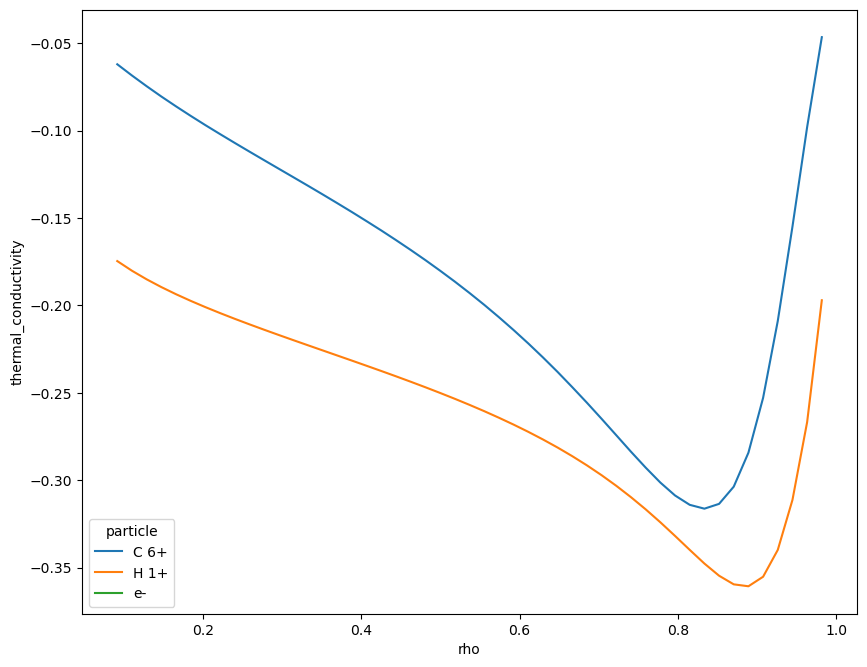

In [47]:
results.thermal_conductivity.plot.line(x="rho")

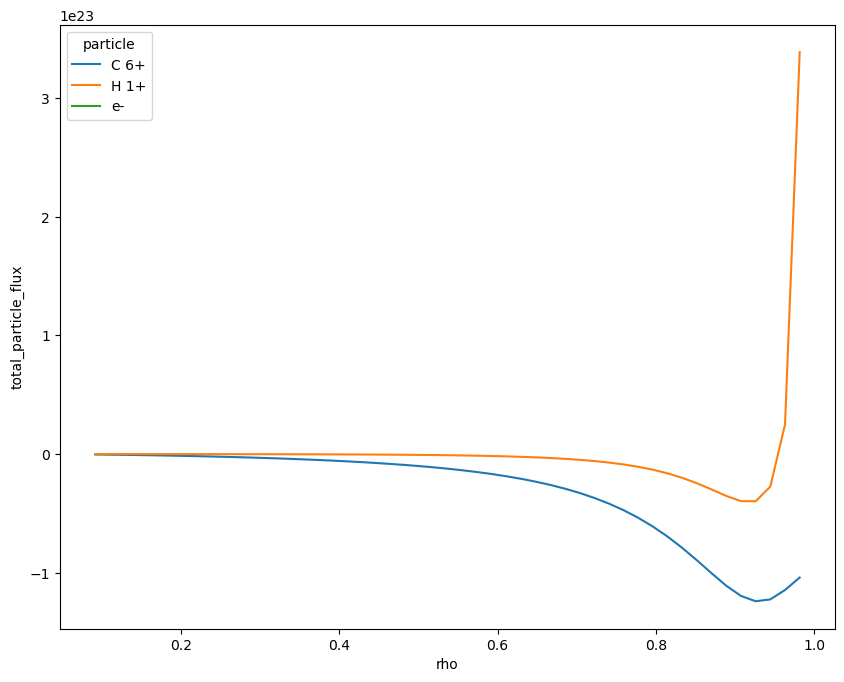

In [48]:
results.total_particle_flux.plot.line(x="rho")

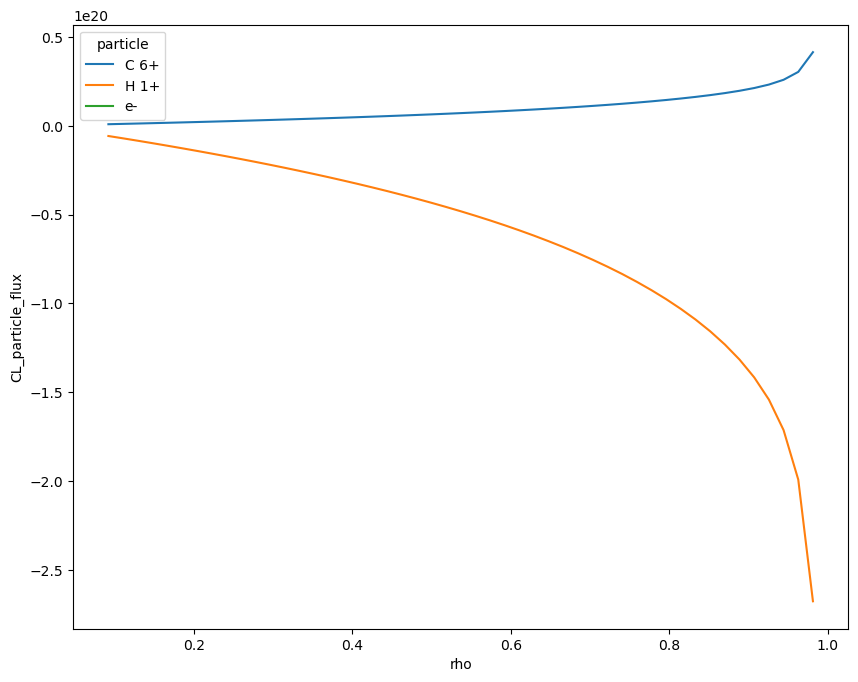

In [49]:
results.CL_particle_flux.plot.line(x="rho")

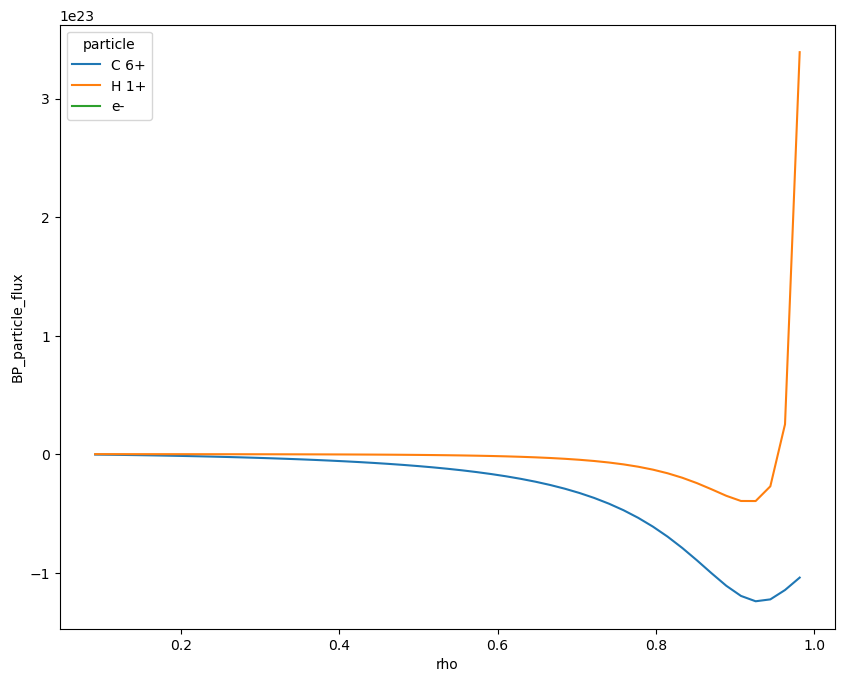

In [50]:
results.BP_particle_flux.plot.line(x="rho")

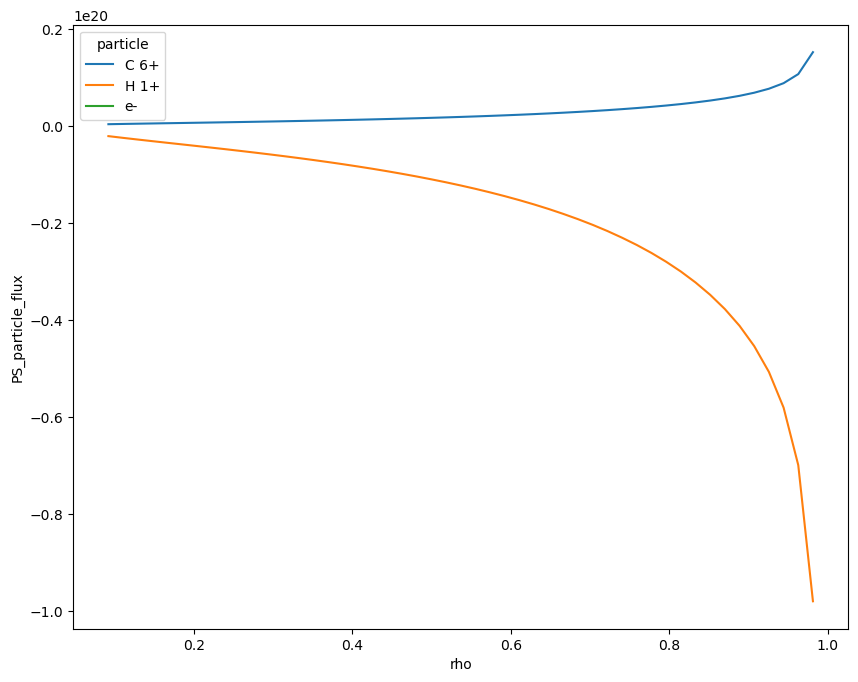

In [51]:
results.PS_particle_flux.plot.line(x="rho")

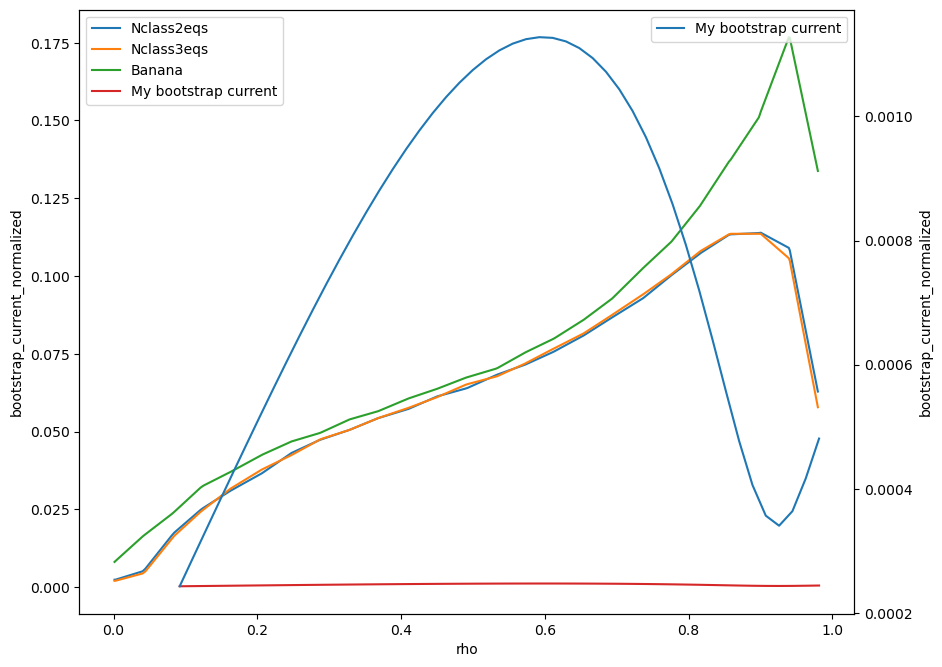

In [52]:
import pandas as pd

df = pd.read_csv("/home/dominik/NSTXplot1.csv")

df.plot.line(x='x')
results.bootstrap_current_normalized.plot.line(x='rho', label="My bootstrap current")
plt.legend()
plt.twinx()
results.bootstrap_current_normalized.plot.line(x='rho', label="My bootstrap current")
plt.legend()